In [1]:
import matplotlib.pyplot as plt

% matplotlib inline

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as DT
import collections, os,pydotplus, StringIO, operator
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import metrics, tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel



os.chdir('C:\Users\jhoukal\Desktop\New folder')

536108

In [3]:
Login = pd.read_csv('LoginData.csv')
Login.rename(columns={ Login.columns[0]: "ENTITY"}, inplace=True)

Partner = pd.read_csv('PartnerData.csv')
Partner.rename(columns={ Partner.columns[0]: "ENTITY"}, inplace=True)

Events = pd.read_csv('EventData.csv')
Events.rename(columns={ Events.columns[0]: "ENTITY"}, inplace=True)

SF = pd.read_csv('Salesforce.csv')
SF.rename(columns={ SF.columns[0]: "ENTITY"}, inplace=True)
SF.drop_duplicates(['ENTITY'], inplace=True)

In [4]:
now=pd.Timestamp(DT.datetime.now()) #for age calculation
Login.loc[:, 'DATE_OF_BIRTH'] = pd.to_datetime(Login.loc[:, 'DATE_OF_BIRTH'])
Login.loc[:, 'AGE'] = (now - Login.loc[:, 'DATE_OF_BIRTH']).astype('<m8[Y]')
Login.drop(['DATE_OF_BIRTH'], axis=1, inplace=True)

In [5]:
df = pd.merge(Login, 
              pd.merge(Events, 
                       Partner, 
                       on='ENTITY', how='outer'),
                  on='ENTITY', how='outer')

df.drop_duplicates(['ENTITY'], inplace=True) #occasional duplicate users here, too. I don't need them. 

df['CONTACT'] = np.where(df['ENTITY'].isin(SF['ENTITY']), True,np.nan) #true/false if member actually contacted. 

In [171]:
df.head()

,FIRST_APP_LOGIN_DATE,FIRST_WEB_LOGIN_DATE,earned_status_adj,hra_completion_date,vc_completion_date,COVERAGE_EFF_DATE,ZIP_CD,AGE,eventdesc,partner_name,CONTACT
ENTITY,,,,,,,,,,,
1.400067e+09,NaN,4/8/2015,Bronze,NaN,NaN,2/23/2015,77064,35-49,NaN,NaN,NaN
1.400078e+09,NaN,11/21/2016,Bronze,NaN,NaN,1/1/2014,97405,35-49,NaN,NaN,1.0
1.400081e+09,4/3/2017,2/8/2013,Platinum,1/1/2018 0:00,3/9/2018 0:00,1/1/2013,32832,50-64,NaN,APPLE,NaN
1.400100e+09,NaN,1/11/2013,Silver,1/29/2018 0:00,2/13/2018 0:00,1/1/2011,55442,35-49,NaN,NaN,1.0
1.400104e+09,4/12/2016,4/12/2016,Platinum,12/1/2017 0:00,NaN,11/3/2014,61115,50-64,NaN,Google Fit,1.0


In [6]:
df.set_index('ENTITY', inplace=True)
print(df.isnull().sum())

FIRST_APP_LOGIN_DATE    276182
FIRST_WEB_LOGIN_DATE     20112
earned_status_adj        20157
hra_completion_date     229520
vc_completion_date      381478
COVERAGE_EFF_DATE        20047
ZIP_CD                   44178
AGE                      20047
eventdesc               498705
partner_name            288187
CONTACT                 457902
dtype: int64


In [7]:
df['AGE'] = pd.cut(df['AGE'], [0, 18, 34, 49, 64, 80], labels=['0-18', '19-34', '35-49', '50-64', '65-80'])

In [8]:
mydata = df.loc[:, (df.columns != 'AGE') & (df.columns != 'earned_status_adj')].notnull().astype('int')
mydata = pd.merge(mydata,df[['AGE','earned_status_adj']],left_index=True, right_index=True)

In [9]:
mydata = pd.get_dummies(mydata, columns=['earned_status_adj'], drop_first=False)

In [10]:
mydata.loc[:, 'AGE'] = mydata.loc[:, 'AGE'].dropna()
mydata = pd.get_dummies(mydata, columns=['AGE'], drop_first=True)

In [11]:
(mydata == 1).sum(axis=1)#sum of conversions by row (member)
(mydata == 1).sum(axis=0)#sum of conversions by column (feature)

FIRST_APP_LOGIN_DATE          259926
FIRST_WEB_LOGIN_DATE          515996
hra_completion_date           306588
vc_completion_date            154630
COVERAGE_EFF_DATE             516061
ZIP_CD                        491930
eventdesc                      37403
partner_name                  247921
CONTACT                        78206
earned_status_adj_Bronze      251615
earned_status_adj_Gold         83230
earned_status_adj_Platinum     68237
earned_status_adj_Silver      112869
AGE_19-34                     131622
AGE_35-49                     205939
AGE_50-64                     158170
AGE_65-80                      14879
dtype: int64

In [172]:
mydata.head()

,FIRST_WEB_LOGIN_DATE,ZIP_CD,hra_completion_date,FIRST_APP_LOGIN_DATE,earned_status_adj_Bronze,partner_name,AGE_35-49,AGE_50-64,vc_completion_date,AGE_19-34,earned_status_adj_Silver,earned_status_adj_Gold,CONTACT,earned_status_adj_Platinum,eventdesc,AGE_65-80,BASE,PRED,OUTCOME
ENTITY,,,,,,,,,,,,,,,,,,,
1.400067e+09,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0.021655,0
1.400078e+09,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0.021655,0
1.400081e+09,1,1,1,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0.422718,0
1.400100e+09,1,1,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0.113295,0
1.400104e+09,1,1,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0.366683,0


In [12]:
mydata = mydata[mydata.sum().sort_values(ascending = False).index] 

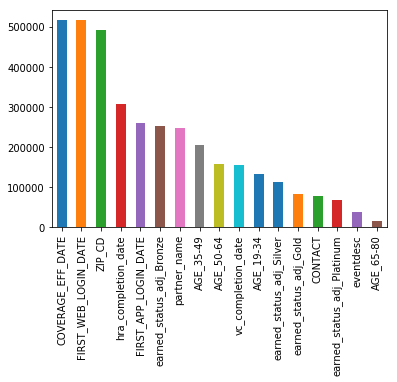

In [13]:
ax = (mydata == 1).sum(axis=0).plot.bar() 

In [14]:
mydata.drop(['COVERAGE_EFF_DATE'], axis=1, inplace=True)


In [15]:
mydata.groupby(mydata.sum(axis=1)).agg(sum)

,FIRST_WEB_LOGIN_DATE,ZIP_CD,hra_completion_date,FIRST_APP_LOGIN_DATE,earned_status_adj_Bronze,partner_name,AGE_35-49,AGE_50-64,vc_completion_date,AGE_19-34,earned_status_adj_Silver,earned_status_adj_Gold,CONTACT,earned_status_adj_Platinum,eventdesc,AGE_65-80
0,0,0,0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0
1,0,0,0,0,0.0,15389,0.0,0.0,0,0.0,0.0,0.0,0,0.0,623,0.0
2,15,0,0,0,10.0,3899,4.0,1.0,0,0.0,0.0,0.0,3696,0.0,221,0.0
3,13418,5383,0,9,13279.0,126,3683.0,1707.0,0,2583.0,72.0,8.0,126,0.0,126,121.0
4,124548,120219,1346,2065,119527.0,783,48054.0,45095.0,147,26091.0,4033.0,928.0,170,97.0,9,5308.0
5,87873,83734,42412,28054,66265.0,9866,34484.0,28597.0,7954,21930.0,16037.0,4198.0,3353,1369.0,421,2843.0
6,80067,76273,58594,40866,31131.0,30816,31865.0,25454.0,26484,20271.0,32580.0,11529.0,5943,4820.0,1258,2451.0
7,90895,88306,85870,73954,17017.0,71643,37603.0,24329.0,28523,27135.0,36861.0,23900.0,11459,13113.0,3832,1825.0
8,78987,77981,78211,75069,3808.0,75384,33367.0,20866.0,56232,23342.0,18529.0,29378.0,21202,27269.0,10863,1408.0
9,33641,33482,33603,33357,578.0,33463,14152.0,10051.0,28738,8704.0,4419.0,11419.0,25705,17225.0,13498,734.0


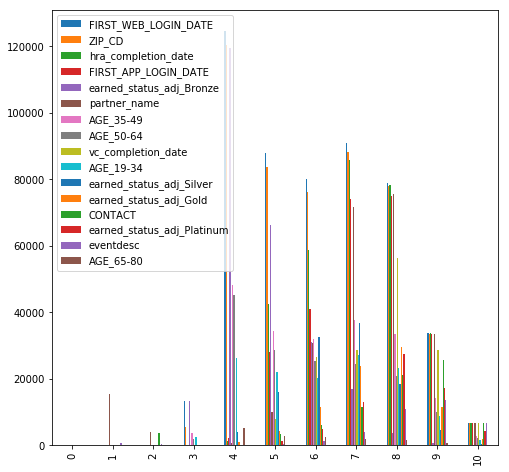

In [16]:
ax = mydata.groupby(mydata.sum(axis=1)).agg(sum).plot.bar(figsize=(8,8))

In [21]:
#baseline
mydata.loc[:,  'BASE'] = np.where((mydata == 1).sum(axis=1) > 5, 1, 0)


In [22]:
np.sqrt(metrics.mean_squared_error(mydata.loc[:, 'CONTACT'], mydata.loc[:, 'BASE']))

0.6501726891028863

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002D2C7DA0>,
      dtype=object)

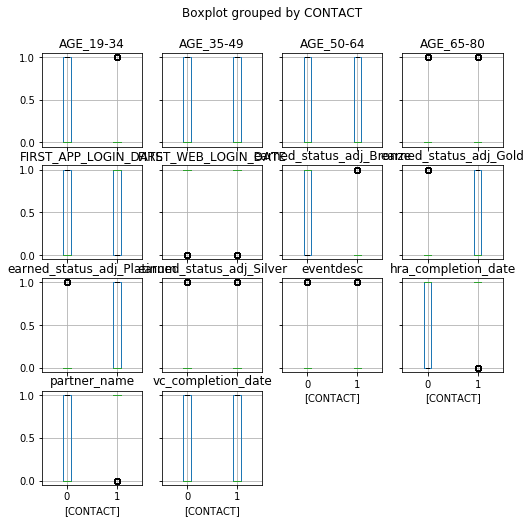

In [161]:
mychartdata.boxplot(by='CONTACT', figsize=(8,8))

AttributeError: 'AxesSubplot' object has no attribute 'groupby'

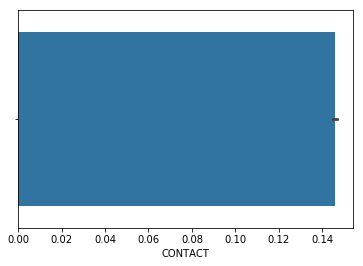

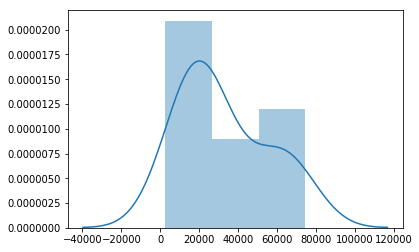

In [244]:
sns.distplot(mychartdata[mychartdata.loc[:, 'CONTACT']==1].groupby('CONTACT').agg(sum))

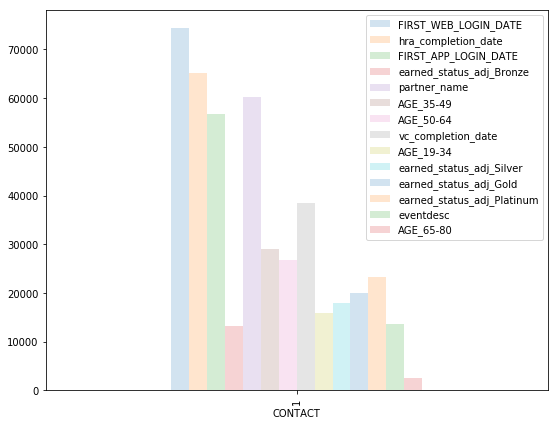

In [234]:
#mychartdata = mychartdata.drop(['OUTCOME', 'ZIP_CD'], axis=1)
ax=mychartdata[mychartdata.loc[:, 'CONTACT']==1].groupby('CONTACT').agg(sum).plot.bar(figsize=(9,7), alpha=0.2)

In [ ]:
dims = (10, 10)
fig, ax = plt.subplots(figsize=dims)
plt.title("Feature Names")
g = sns.barplot(ax=ax, x=feature_cols, y=treeclf.feature_importances_).set_xticklabels(rotation=90,labels=feature_cols)

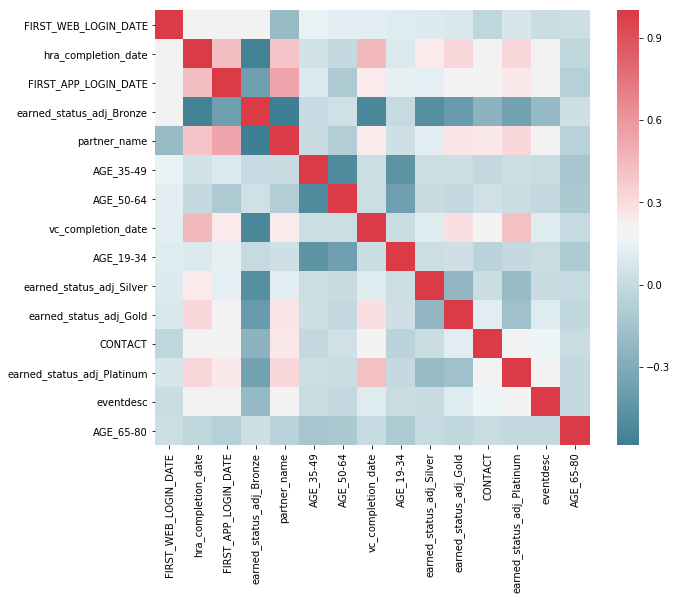

In [192]:
corr = mychartdata.corr()
f, ax = plt.subplots(figsize=(10, 8))
g = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap='PRED'),
            square=True, ax=ax)

In [25]:
feature_cols = [i for i in mydata if ('CONTACT' not in i and 'pred' not in i and 'BASE' not in i)]
X = mydata.loc[:, feature_cols]
y = mydata.loc[:, 'CONTACT']

In [27]:
X = mydata.loc[:, feature_cols]
y = mydata.loc[:, 'CONTACT']

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [85]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,FIRST_WEB_LOGIN_DATE,0.000000
1,ZIP_CD,0.000000
2,hra_completion_date,0.026397
3,FIRST_APP_LOGIN_DATE,0.000000
4,earned_status_adj_Bronze,0.073158
5,partner_name,0.643184
6,AGE_35-49,0.000000
7,AGE_50-64,0.000000
8,vc_completion_date,0.000000
9,AGE_19-34,0.000000


In [94]:
myreg = DecisionTreeRegressor()
myreg.fit(X, y)
y_pred = myreg.predict(X)

np.sqrt(metrics.mean_squared_error(y, y_pred))

0.3303639497783338

In [30]:
X_test = mydata.loc[:, feature_cols]
y_test = mydata.loc[:, 'CONTACT']
y_pred = myreg.predict(X_test)

y_pred

array([0.0216545 , 0.0216545 , 0.42271838, ..., 0.19327951, 0.19327951,
       0.19327951])

In [31]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.3303639497783338

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 89)

In [109]:
rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [110]:
print(SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_train).shape)
print(SelectFromModel(rfreg, threshold='median', prefit=True).transform(X_train).shape)

(402081L, 5L)
(402081L, 8L)


In [111]:
X_important =  SelectFromModel(rfreg, threshold='mean', prefit=True).transform(X_test)
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)

scores = cross_val_score(rfreg, X_important, y_test, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

#lower -- let's say better

0.3333360553714874

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [44]:
y_pred

array([0.0216545 , 0.0216545 , 0.42271838, ..., 0.19327951, 0.19327951,
       0.19327951])

In [113]:
mydata.loc[:, 'PRED'] = y_pred

In [114]:
f = mydata.loc[mydata.loc[:, 'PRED'] > .49, :]

In [115]:
mydata.loc[:, 'OUTCOME'] = np.where(mydata.loc[:, 'PRED']>=0.5, 1, 0)

In [116]:
mydata.loc[mydata.loc[:, 'OUTCOME'] == 1, :].head()

,FIRST_WEB_LOGIN_DATE,ZIP_CD,hra_completion_date,FIRST_APP_LOGIN_DATE,earned_status_adj_Bronze,partner_name,AGE_35-49,AGE_50-64,vc_completion_date,AGE_19-34,earned_status_adj_Silver,earned_status_adj_Gold,CONTACT,earned_status_adj_Platinum,eventdesc,AGE_65-80,BASE,PRED,OUTCOME
ENTITY,,,,,,,,,,,,,,,,,,,
1.403342e+09,1,1,1,1,0,1,0,1,1,0,0,0,1,1,1,0,1,0.575121,1
1.403672e+09,1,1,1,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0.510278,1
1.403672e+09,1,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0.575121,1
1.403672e+09,1,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0.575121,1
1.403673e+09,1,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0.575121,1


In [103]:
y_predict = treeclf.predict(X_test)
accuracy_score(y_test, y_predict)

NameError: name 'accuracy_score' is not defined

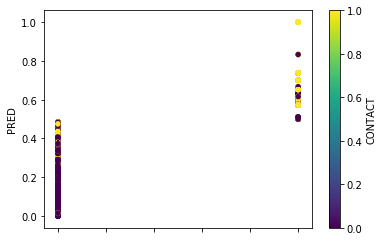

In [104]:
ax = mydata.plot(kind='scatter', x='OUTCOME', y='PRED', 
                 c='CONTACT', colormap='viridis')

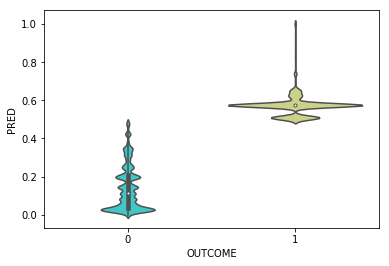

In [105]:
sns.violinplot(x='OUTCOME', y='PRED', data=mydata,palette='rainbow')

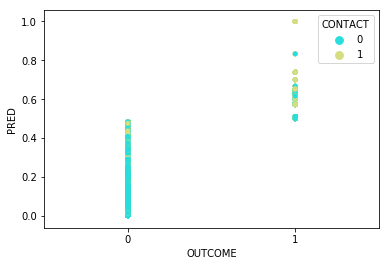

In [213]:
sns.stripplot(x='OUTCOME', y='PRED', data=mydata,palette='rainbow', hue='CONTACT');

In [112]:
mydata.loc[:, 'OUTCOME'].sum()


4038

![Tree for Final](my_tree.png)

In [62]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

os.system('dot -Tpng my_tree.dot -o my_tree.png')

0

In [117]:

sorted(list(zip(feature_cols, treeclf.feature_importances_)), key=operator.itemgetter(1))

[('FIRST_WEB_LOGIN_DATE', 0.0),
 ('ZIP_CD', 0.0),
 ('FIRST_APP_LOGIN_DATE', 0.0),
 ('AGE_35-49', 0.0),
 ('AGE_50-64', 0.0),
 ('vc_completion_date', 0.0),
 ('AGE_19-34', 0.0),
 ('earned_status_adj_Silver', 0.0),
 ('earned_status_adj_Gold', 0.0),
 ('AGE_65-80', 0.0),
 ('hra_completion_date', 0.026396925481480142),
 ('earned_status_adj_Bronze', 0.07315759104049478),
 ('eventdesc', 0.09339277062184427),
 ('earned_status_adj_Platinum', 0.1638688601055948),
 ('partner_name', 0.6431838527505859)]

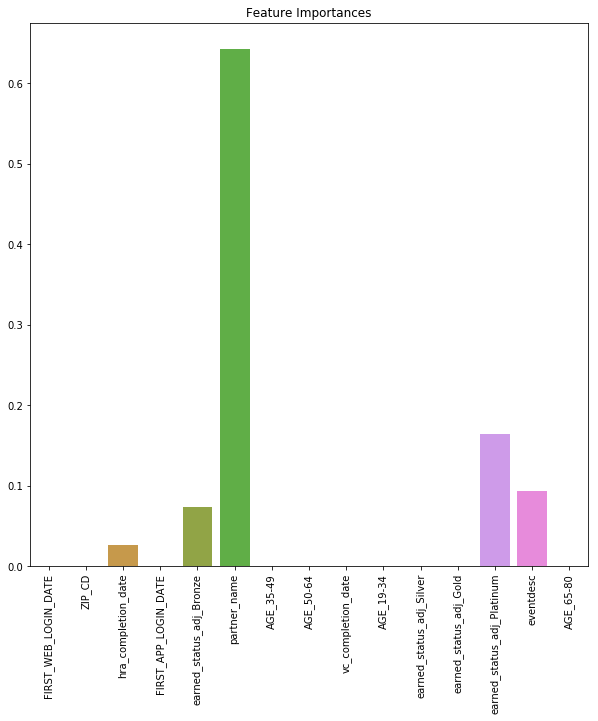

In [188]:

dims = (10, 10)
fig, ax = plt.subplots(figsize=dims)
plt.title("Feature Importances")
g = sns.barplot(ax=ax, x=feature_cols, y=treeclf.feature_importances_).set_xticklabels(rotation=90,labels=feature_cols)


[Text(0,0,u'FIRST_WEB_LOGIN_DATE'),
 Text(0,0,u'ZIP_CD'),
 Text(0,0,u'hra_completion_date'),
 Text(0,0,u'FIRST_APP_LOGIN_DATE'),
 Text(0,0,u'earned_status_adj_Bronze'),
 Text(0,0,u'partner_name'),
 Text(0,0,u'AGE_35-49'),
 Text(0,0,u'AGE_50-64'),
 Text(0,0,u'vc_completion_date'),
 Text(0,0,u'AGE_19-34'),
 Text(0,0,u'earned_status_adj_Silver'),
 Text(0,0,u'earned_status_adj_Gold'),
 Text(0,0,u'earned_status_adj_Platinum'),
 Text(0,0,u'eventdesc'),
 Text(0,0,u'AGE_65-80')]

In [196]:

predicted = treeclf.predict(mydata.loc[:, feature_cols])
expected = mydata.loc[:, 'CONTACT']

In [211]:
ff.head()

,0
CONTACT,
0,0
1,0
0,0
1,0
1,0
